In [1]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from helper_evaluation import set_all_seeds, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize

In [2]:
torch.cuda.empty_cache()
random_seed = 42
train_root = 'train_images'
NUM_EPOCHS = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

set_all_seeds(random_seed)

In [3]:
train_table = pd.read_csv('train.csv')
train_table.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train_table.shape

(21397, 2)

In [5]:
train_table['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
train_paths = [os.path.join(train_root, file) for file in train_table['image_id']]
train_labels = train_table['label'].values

In [7]:
# sizes = set()
# modes = set()
# for path in train_paths:
#     pic = Image.open(path)
#     sizes.add(pic.size)
#     modes.add(pic.mode)
# print(sizes)
# print(modes)

In [8]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    #transforms.Scale(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((400,300))
    img_tensor = preprocess(img_pil)
    return img_tensor

In [9]:
class MyDataset(Dataset):
    def __init__(self, img_paths, labels, loader=default_loader):
        self.img_paths = img_paths
        self.labels = labels
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, label = self.img_paths[index], self.labels[index]
        img = self.loader(img_path)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [10]:
dataset = MyDataset(train_paths, train_labels)
len(dataset)*np.array([0.8,0.05,0.15])

array([17117.6 ,  1069.85,  3209.55])

In [11]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [17118 ,  1070,  3209], generator=torch.Generator().manual_seed(random_seed))

In [12]:
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
model = torchvision.models.resnext50_32x4d(pretrained=True)
model = model.to(device)

In [14]:
optimizer = torch.optim.SGD(model.parameters(), momentum=0.7, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [15]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)


Epoch: 001/030 | Batch 0000/2853 | Loss: 8.3085
Epoch: 001/030 | Batch 0100/2853 | Loss: 0.7777
Epoch: 001/030 | Batch 0200/2853 | Loss: 1.0424
Epoch: 001/030 | Batch 0300/2853 | Loss: 1.7393
Epoch: 001/030 | Batch 0400/2853 | Loss: 0.4987
Epoch: 001/030 | Batch 0500/2853 | Loss: 0.3909
Epoch: 001/030 | Batch 0600/2853 | Loss: 1.3452
Epoch: 001/030 | Batch 0700/2853 | Loss: 0.8902
Epoch: 001/030 | Batch 0800/2853 | Loss: 0.4518
Epoch: 001/030 | Batch 0900/2853 | Loss: 0.7811
Epoch: 001/030 | Batch 1000/2853 | Loss: 0.6549
Epoch: 001/030 | Batch 1100/2853 | Loss: 0.9447
Epoch: 001/030 | Batch 1200/2853 | Loss: 0.1471
Epoch: 001/030 | Batch 1300/2853 | Loss: 0.2642
Epoch: 001/030 | Batch 1400/2853 | Loss: 0.7375
Epoch: 001/030 | Batch 1500/2853 | Loss: 0.3040
Epoch: 001/030 | Batch 1600/2853 | Loss: 1.0803
Epoch: 001/030 | Batch 1700/2853 | Loss: 0.7086
Epoch: 001/030 | Batch 1800/2853 | Loss: 0.2982
Epoch: 001/030 | Batch 1900/2853 | Loss: 2.0580
Epoch: 001/030 | Batch 2000/2853 | Loss:

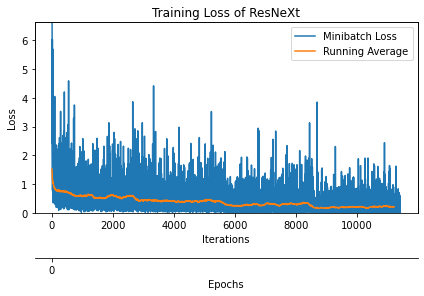

In [16]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.title('Training Loss of ResNeXt')
plt.savefig('resnextTL.pdf')
plt.show()

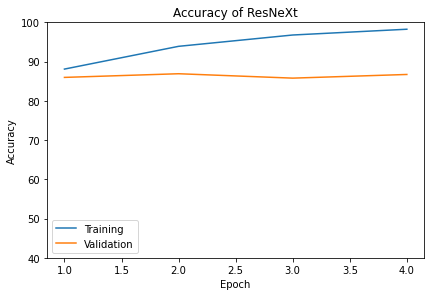

In [17]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([40, 100])
plt.title('Accuracy of ResNeXt')
plt.savefig('resnextACC.pdf')
plt.show()

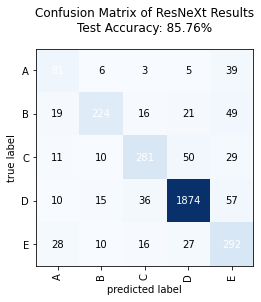

In [19]:
class_dict = {0: 'A',
              1: 'B',
              2: 'C',
              3: 'D',
              4: 'E',}
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=device)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.title('Confusion Matrix of ResNeXt Results\nTest Accuracy: 85.76%')
plt.savefig('resnextCM.pdf')
plt.show()

In [20]:
torch.save(model.state_dict(), 'resnext.pkl')